In [29]:
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
from imutils.video import VideoStream
import numpy as np
import argparse
import imutils
import time
import cv2
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import json

In [41]:
def detect_and_predict_mask(image:np.ndarray, face_net, mask_net):
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
    
    face_net.setInput(blob)
    detections = face_net.forward() 

    faces = []
    locations = []
    preds = []

    for i in range(0, detections.shape[2]):
        conf = detections[0, 0, i, 2]

        if conf > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")    

            (x1, y1) = (max(0, x1), max(0, y1))
            (x2, y2) = (min(w - 1, x2), min(h - 1, y2))

            face = image[y1:y2, x1:x2]
            if face.any():
                face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
                face = cv2.resize(face, (224, 224))
                face = img_to_array(face)
                face = preprocess_input(face)

                faces.append(face)  
                locations.append((x1, y1, x2, y2))
    
    if len(faces) > 0:
        faces = np.array(faces, dtype="float32")
        preds = mask_net.predict(faces, batch_size=32)  
    
    return (locations, preds)

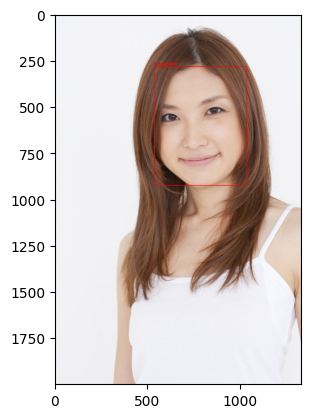

In [6]:
# prepare models
# prototxt_path = os.path.sep.join(["face_detector", "deploy.prototxt"])
# weights_path = os.path.sep.join(["face_detector",
#     "res10_300x300_ssd_iter_140000.caffemodel"])
# mask_model_path = os.path.sep.join(["mask_detector.model"])

prototxt_path = "../models/face/v1/deploy.prototxt"
weights_path = "../models/face/v1/res10_300x300_ssd_iter_140000.caffemodel"
mask_model_path = "../models/mask/mask_detector.model"

face_net = cv2.dnn.readNet(prototxt_path, weights_path)
mask_net = load_model(mask_model_path)

# image 
image_path = "/Users/lequangnhat/My Study/3-CNN-Tensorflow/11-skintone-classification/Skintone-Detector/data/1095270.jpg"
image = cv2.imread(image_path)

(locations, preds) = detect_and_predict_mask(image, face_net, mask_net)

for (box, pred) in zip (locations, preds):
    x1, y1, x2, y2 = box
    mask, without_mask = pred

    label = "Mask" if mask > without_mask else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    label = "{}: {:.2f}%".format(label, max(mask, without_mask) * 100)

    cv2.putText(image, label, (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [82]:
df = pd.read_csv("face_analysis_data/labels.csv")
df

,file_name,height,width,bbox,age,race,masked,skintone,emotion,gender
0,100013282.jpg,1333,2000,"[934.0000000000097, 144.82228672769534, 238.24...",20-30s,Caucasian,unmasked,mid-light,Neutral,Male
1,100016175.jpg,1333,2000,"[1094.0513571635438, 422.91772295627203, 55.45...",20-30s,Caucasian,unmasked,light,Neutral,Male
2,10004189.jpg,2000,1333,"[419.93871061403877, 269.1250391680045, 377.19...",20-30s,Mongoloid,unmasked,light,Happiness,Female
3,100104575.jpg,1333,2000,"[1490.6909678848915, 676.0000000000097, 37.553...",20-30s,Caucasian,unmasked,mid-light,Neutral,Male
4,100104600.jpg,2000,1333,"[549.169724453414, 92.52040334013152, 306.8821...",20-30s,Caucasian,unmasked,mid-light,Happiness,Female
...,...,...,...,...,...,...,...,...,...,...
15305,image_2713.jpg,1024,1024,"[244.71717171717162, 176.66666666666654, 587.2...",40-50s,Caucasian,unmasked,mid-light,Happiness,Male
15306,image_3332.jpg,1024,1024,"[265.6338028169031, 174.2441314553992, 584.727...",Senior,Caucasian,unmasked,light,Happiness,Female
15307,image_6905.jpg,1024,1024,"[251.3434343434343, 184.7171717171712, 500.535...",20-30s,Caucasian,unmasked,light,Neutral,Male
15308,image_4080.jpg,1024,1024,"[222.72727272727235, 179.8181818181809, 586.90...",Kid,Caucasian,unmasked,light,Happiness,Female


In [ ]:
df.dropna(inplace=True)
df

In [48]:
def mask_prediction(image:np.ndarray, bbox:(float, float, float, float), mask_net):
    x, y, w, h = map(int, bbox)
    image_crop = image[y:y+h, x:x+w]
    face = cv2.cvtColor(image_crop, cv2.COLOR_BGR2RGB)
    face = cv2.resize(face, (224, 224))
    face = img_to_array(face)
    face = preprocess_input(face)

    face = np.expand_dims(face, axis=0)
    preds = mask_net.predict(face, batch_size=32)

    return preds

def face_prediction(image_original:np.ndarray, face_net):
    (h, w) = image_original.shape[:2]
    blob = cv2.dnn.blobFromImage(image_original, 1.0, (300, 300),
        (104.0, 177.0, 123.0))
    
    face_net.setInput(blob)
    detections = face_net.forward() 

    faces = []
    locations = []

    for i in range(0, detections.shape[2]):
        conf = detections[0, 0, i, 2]

        if conf > 0.5:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (x1, y1, x2, y2) = box.astype("int")    

            (x1, y1) = (max(0, x1), max(0, y1))
            (x2, y2) = (min(w - 1, x2), min(h - 1, y2))

            face = image_original[y1:y2, x1:x2]
            if face.any():
                faces.append(face)  
                locations.append((x1, y1, x2, y2))
    
    return (locations, faces)

# utils
def get_list_bbox(bbox_pd) -> (float, float, float, float):
    json_bbox = json.loads(bbox_pd)
    float_test_bbox = [float(i) for i in json_bbox]
    return float_test_bbox


def get_masked_or_unmasked(preds_mask):
    for pred in preds_mask:
        mask, without_mask = pred
        if mask > without_mask:
            return "masked"  
        else:
            return "unmasked"

In [11]:
filtered_masked_df = df[df["masked"] == 'masked']
filtered_masked_df  

,file_name,height,width,bbox,age,race,masked,skintone,emotion,gender
52,10114066.jpg,1333,2000,"[831.0022505626372, 230.99999999999912, 304.99...",20-30s,Mongoloid,masked,light,Neutral,Female
82,10152563.jpg,2000,1333,"[540.7418849961368, 786.3081575600074, 266.786...",20-30s,Mongoloid,masked,mid-light,Neutral,Male
220,10444280.jpg,2000,1331,"[531.2058495984999, 547.0000000000022, 263.691...",20-30s,Mongoloid,masked,light,Sadness,Male
245,10492403.jpg,1333,2000,"[1297.612392528763, 195.0599033651751, 299.387...",20-30s,Mongoloid,masked,light,Happiness,Female
252,10501434.jpg,1333,2000,"[1201.7498914431953, 392.9911285510481, 204.25...",20-30s,Mongoloid,masked,light,Sadness,Female
...,...,...,...,...,...,...,...,...,...,...
13594,98920125.jpg,728,2000,"[847.6593840901464, 132.5977318158622, 140.382...",20-30s,Caucasian,masked,mid-light,Neutral,Male
13599,99049532.jpg,967,2000,"[316.5131480090097, 122.5539541265793, 222.197...",20-30s,Caucasian,masked,light,Surprise,Male
13615,99203925.jpg,1333,2000,"[909.8195364802665, 69.26515630151908, 118.681...",20-30s,Mongoloid,masked,light,Neutral,Female
13646,9964060.jpg,2000,1333,"[495.67908398557864, 546.0398899981532, 326.16...",20-30s,Mongoloid,masked,light,Neutral,Male


In [13]:
base_folder = "/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data"

image_paths = glob.glob(os.path.join(base_folder, "*.jpg"))

image_paths[:5]

['/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/100013282.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/100016175.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/10004189.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/100104575.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/100104600.jpg']

In [15]:

filtered_image_paths = [path for path in image_paths if os.path.basename(path) in filtered_masked_df['file_name'].tolist()]
filtered_image_paths[:5]

['/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/10114066.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/10152563.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/10444280.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/10492403.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/10501434.jpg']

In [42]:
prototxt_path = os.path.sep.join(["face_detector", "deploy.prototxt"])
weights_path = os.path.sep.join(["face_detector",
    "res10_300x300_ssd_iter_140000.caffemodel"])
mask_model_path = os.path.sep.join(["mask_detector.model"])

face_net = cv2.dnn.readNet(prototxt_path, weights_path)
mask_net = load_model(mask_model_path)

[873.3464492614143, 344.0000000000004, 246.79078676940807, 313.00000000000017]
[[0.13347442 0.8665256 ]]


<Figure size 640x480 with 0 Axes>

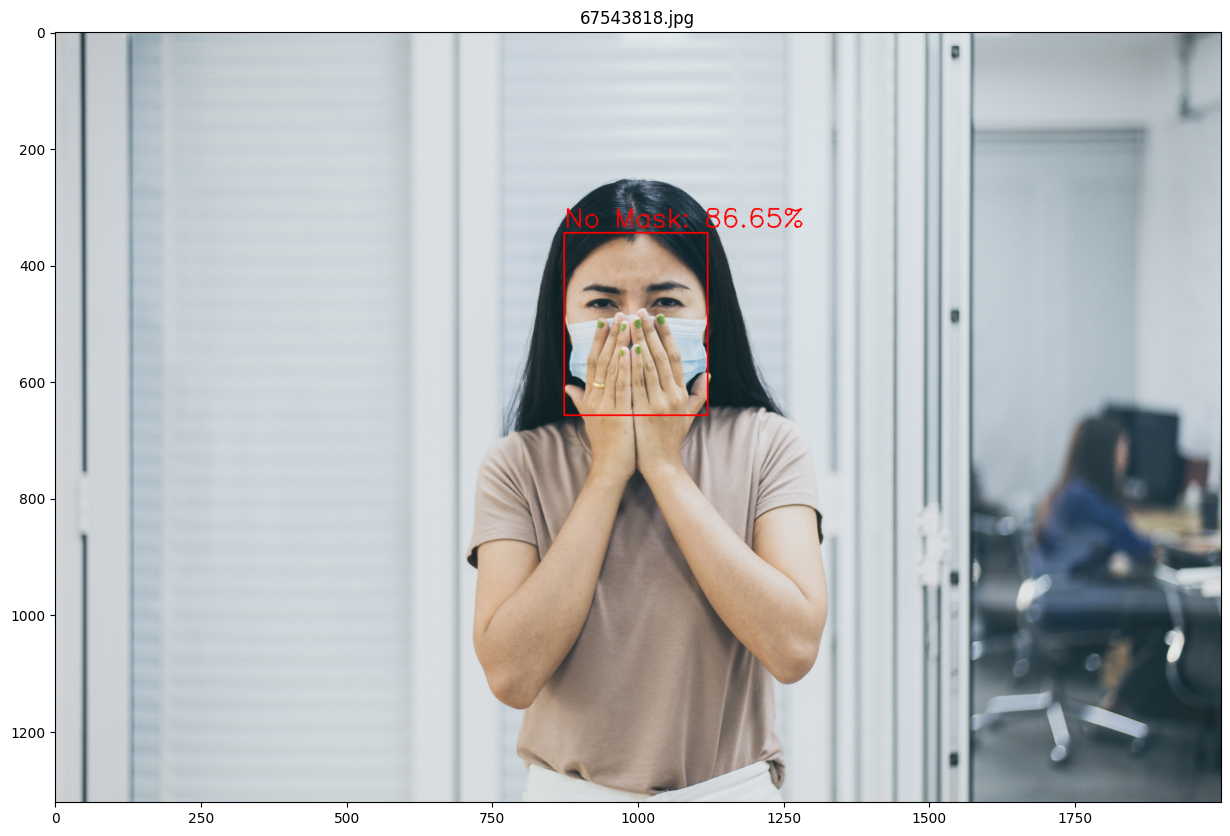

In [102]:
test_path = filtered_image_paths[196] # 27, 196
test_image = cv2.imread(test_path)
test_bbox = filtered_masked_df[filtered_masked_df['file_name'] == os.path.basename(test_path)]['bbox'].values

float_test_bbox = get_list_bbox(test_bbox[0])
print(float_test_bbox)
x,y,w,h = map(int, float_test_bbox)  



pred_mask = mask_prediction(test_image, float_test_bbox, mask_net)

for pred in pred_mask:
    mask, unmasked = pred

    label = "Mask" if mask > unmasked else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)

    label = "{}: {:.2f}%".format(label, max(mask, unmasked) * 100)

    cv2.putText(test_image, label, (x, y - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 1.5, color, 2)
    
    cv2.rectangle(test_image, (x, y), (x + w, y + h), color, 2)
    
print(pred_mask)
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB) 
plt.tight_layout() 
plt.figure(figsize=(20, 10))  
plt.imshow(test_image)
plt.title(os.path.basename(test_path))
plt.show()


In [57]:
result_maksed_df = pd.DataFrame(columns=["file_name", "bbox", "masked"])

list_data = []
for path in filtered_image_paths:
    image = cv2.imread(path)
    bbox = filtered_masked_df[filtered_masked_df['file_name'] == os.path.basename(path)]['bbox'].values
    float_bbox = get_list_bbox(bbox[0])
    preds_mask = mask_prediction(image, float_bbox, mask_net)
    masked_or_unmasked = get_masked_or_unmasked(preds_mask)
    list_data.append([os.path.basename(path), float_bbox, masked_or_unmasked])

result_maksed_df = pd.DataFrame(list_data, columns=["file_name", "bbox", "masked"])
value_counts = result_maksed_df['masked'].value_counts()

total_masked_row = {
    "file_name": "total_masked",
    "bbox": "",
    "masked": value_counts['masked']
}

# total_unmasked_row = {
#     "file_name": "total_unmasked",
#     "bbox": "",
#     "masked": value_counts['unmasked']
# }   
result_maksed_df = pd.concat([result_maksed_df, pd.DataFrame([total_masked_row])])
# result_maksed_df.append(total_unmasked_row, ignore_index=True)

result_maksed_df


,file_name,bbox,masked
0,10114066.jpg,"[831.0022505626372, 230.99999999999912, 304.99...",masked
1,10152563.jpg,"[540.7418849961368, 786.3081575600074, 266.786...",masked
2,10444280.jpg,"[531.2058495984999, 547.0000000000022, 263.691...",masked
3,10492403.jpg,"[1297.612392528763, 195.0599033651751, 299.387...",masked
4,10501434.jpg,"[1201.7498914431953, 392.9911285510481, 204.25...",masked
...,...,...,...
500,99049532.jpg,"[316.5131480090097, 122.5539541265793, 222.197...",masked
501,99203925.jpg,"[909.8195364802665, 69.26515630151908, 118.681...",masked
502,9964060.jpg,"[495.67908398557864, 546.0398899981532, 326.16...",masked
503,image_2864.jpg,"[190.41414141414097, 156.08080808080797, 559.8...",unmasked


In [ ]:

test_df = pd.DataFrame(columns=["ID", "Name"])

list_data_1 = []
list_data_2 = []
# Duyệt qua 10 lần để thêm dữ liệu
for i in range(1, 11):
    # Tạo một dictionary chứa dữ liệu mới
    list_data_1.append([i,f"Name_{i}"])


    
    # Thêm dữ liệu vào DataFrame


test_df = pd.DataFrame(list_data_1, columns=["ID", "Name"])
# In kết quả
print(test_df)

In [62]:
filtered_result_masked_df = result_maksed_df[result_maksed_df['masked'] == 'unmasked']
filtered_result_masked_df

,file_name,bbox,masked
27,1359967.jpg,"[475.6060176991154, 418.90909090909224, 328.39...",unmasked
80,47336121.jpg,"[643.9999999999983, 208.31602490436921, 189.58...",unmasked
83,47381993.jpg,"[486.2573444717603, 632.22453069251, 375.74265...",unmasked
84,48066618.jpg,"[628.3917188935891, 156.00000000000026, 52.640...",unmasked
88,53612950.jpg,"[852.4784999479652, 460.2096595123323, 76.8258...",unmasked
89,54097890.jpg,"[1113.8469178392543, 422.9999999999992, 193.78...",unmasked
196,67543818.jpg,"[873.3464492614143, 344.0000000000004, 246.790...",unmasked
259,70499243.jpg,"[749.9999999999999, 490.999999999998, 137.1109...",unmasked
263,70775993.jpg,"[618.7767234487306, 297.0000000000007, 145.477...",unmasked
302,73523376.jpg,"[177.73019271948613, 20.857142857142783, 347.3...",unmasked


# UNMASKED PREDICTION


In [83]:
filtered_unmasked_df = df[df["masked"] == 'unmasked']

filtered_unmasked_image_paths = [path for path in image_paths if os.path.basename(path) in filtered_unmasked_df['file_name'].tolist()] 
filtered_unmasked_image_paths[:5] 

['/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/100013282.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/100016175.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/10004189.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/100104575.jpg',
 '/Volumes/BOOTCAMP/Users/Le Quang Nhat/Downloads/Face-Analysis/data/mnt/md0/projects/sami-hackathon/private/data/100104600.jpg']

In [87]:
result_unmaksed_df = pd.DataFrame(columns=["file_name", "bbox", "masked"])

list_data = []
for path in filtered_unmasked_image_paths:
    image = cv2.imread(path)
    bbox = filtered_unmasked_df[filtered_unmasked_df['file_name'] == os.path.basename(path)]['bbox'].values
    float_bbox = get_list_bbox(bbox[0])
    preds_mask = mask_prediction(image, float_bbox, mask_net)
    masked_or_unmasked = get_masked_or_unmasked(preds_mask)
    list_data.append([os.path.basename(path), float_bbox, masked_or_unmasked])

result_unmaksed_df = pd.DataFrame(list_data, columns=["file_name", "bbox", "masked"])


In [88]:
value_counts = result_unmaksed_df['masked'].value_counts()

total_unmasked_row = {
    "file_name": "total_masked",
    "bbox": "",
    "masked": value_counts['unmasked']
}

result_unmaksed_df = pd.concat([result_unmaksed_df, pd.DataFrame([total_unmasked_row])])  


In [89]:
result_unmaksed_df

,file_name,bbox,masked
0,100013282.jpg,"[934.0000000000097, 144.82228672769534, 238.24...",unmasked
1,100016175.jpg,"[1094.0513571635438, 422.91772295627203, 55.45...",unmasked
2,10004189.jpg,"[419.93871061403877, 269.1250391680045, 377.19...",unmasked
3,100104575.jpg,"[1490.6909678848915, 676.0000000000097, 37.553...",unmasked
4,100104600.jpg,"[549.169724453414, 92.52040334013152, 306.8821...",unmasked
...,...,...,...
14496,image_9953.jpg,"[222.49268292682925, 184.53170731707297, 574.4...",unmasked
14497,image_9989.jpg,"[65.02715466351692, 138.65525383707083, 648.62...",unmasked
14498,image_999.jpg,"[286.5697511858946, 149.32731606381185, 606.76...",unmasked
14499,image_9995.jpg,"[245.8408705252417, 165.17827626918515, 562.52...",unmasked


In [ ]:
for test_path in filtered_image_paths[:100]:
    # test_path = filtered_image_paths[432] # 27, 196
    test_image = cv2.imread(test_path)
    pred_bboxes, faces = face_prediction(test_image, face_net)
    print(pred_bboxes)
    test_bbox = filtered_masked_df[filtered_masked_df['file_name'] == os.path.basename(test_path)]['bbox'].values

    float_test_bbox = get_list_bbox(test_bbox[0])
    print(float_test_bbox)
    x,y,w,h = map(int, float_test_bbox)  

    color_label = (0, 255, 0)
    color_pred = (255, 0, 0)
    cv2.rectangle(test_image, (x, y), (x + w, y + h), (0, 255, 0), 10)
    cv2.putText(test_image, "label", (x, y - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 1.5, color_label, 2)

    for box in pred_bboxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(test_image, (x1, y1), (x2, y2), color_pred, 2)
        cv2.putText(test_image, "pred", (x2, y2+10),cv2.FONT_HERSHEY_COMPLEX, 1.5, color_pred, 2)

    test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB) 
    plt.tight_layout() 
    plt.figure(figsize=(20, 10))  
    plt.imshow(test_image)
    plt.title(os.path.basename(test_path))
plt.show()